# Time Series Modelling

_____


## Outline of Time Series Modelling

### 1. Introduction
  - 1.1 Common use cases from different disciplines
  - 1.2 Common characteristics of time series
  
### 2. ETSDA, ARIMA Model Formulation
  - 2.1 The notion of stochastic processes, time series, and stationarity
  - 2.2 Exploratory Time Series Data Analysis
  - 2.3 Mathematical formulation of ARIMA models
  
### 3. ARIMA Modeling
  - 3.1 Model Identification
  - 3.2 Model Diagnostic Checking
  - 3.3 Model performane evaluation (in-sample fit)
  - 3.4 Forecasting and forecast evaluation 

### 4. SARIMA  Modeling
  - 4.1 Mathematical formulation of Seasonal ARIMA (SARIMA) models
  - 4.2 Building a seasonal ARIMA model for forecasting
  
### 5. Closing Remarks: Practical suggestions and other topics
  

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import some common modules, ensure that MatplotLib plots figures are inline.

In [1]:
# Support hot reloading for widgets
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'


# To support both python 2 and python 3
from __future__ import absolute_import, division, print_function

# Common Imports
import pandas as pd
import numpy as np

pd.core.common.is_list_like = pd.api.types.is_list_like
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn plotting style
sns.set(style='ticks', context='poster')

# Support widgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

# Config notebook options
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


_____

## Exploratory Data Analysis

Here we will explore different time series data sets as example, on different types of data we will deal with.

### Airline Passengers data set (*Seasonal Trend*)



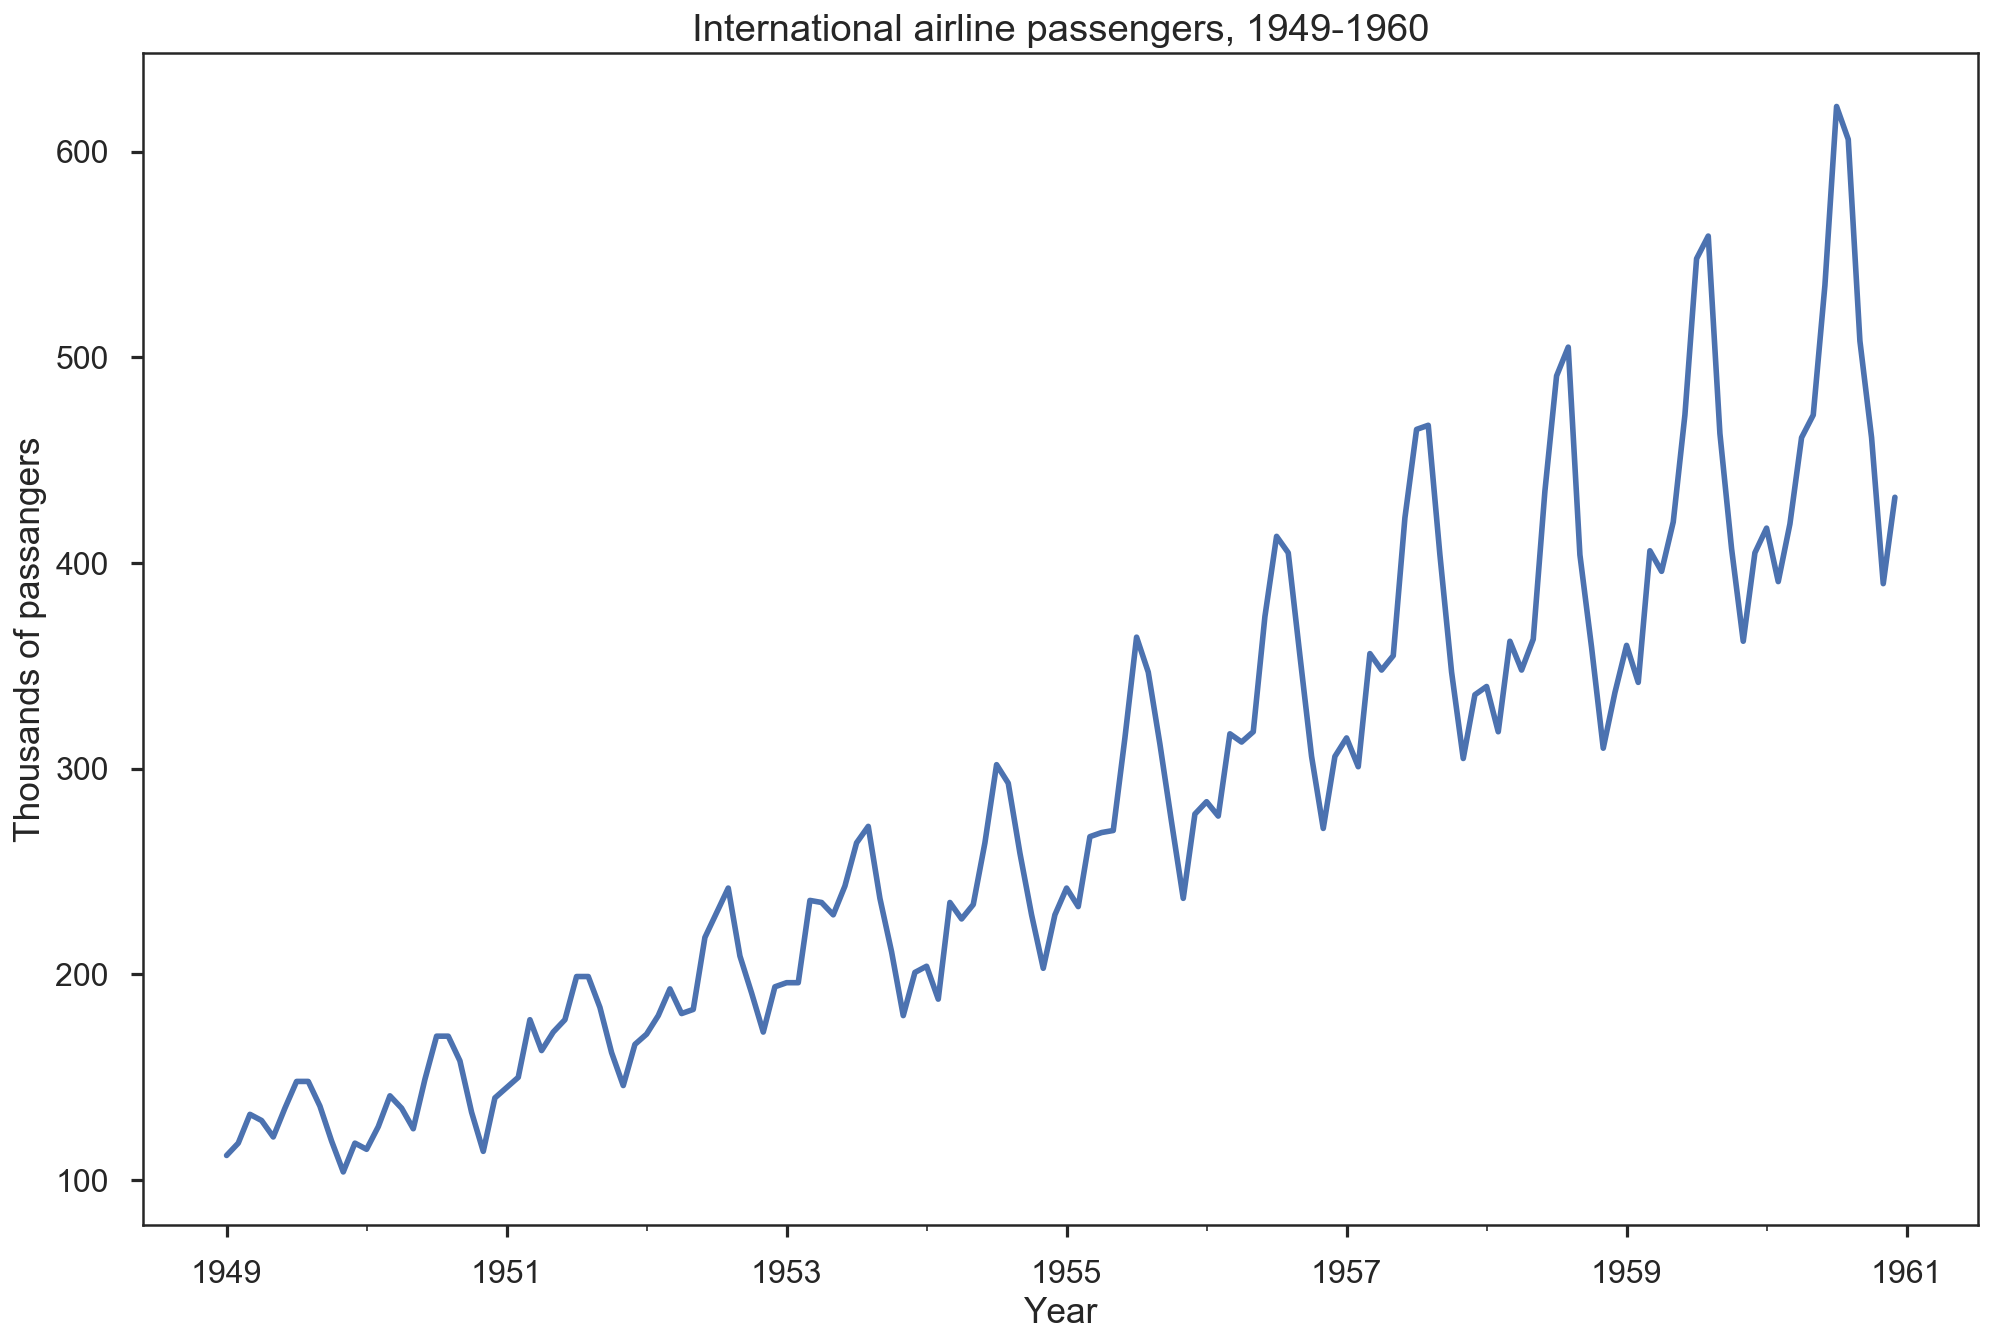

In [8]:
# Load the data
air = pd.read_csv('data/international-airline-passengers.csv',
                header=0, index_col=0,parse_dates=[0])

# Examine the annual trend in the data
fig, ax = plt.subplots(figsize=(14,10))

# Here we are renaming the column
air = air.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'n_pass_thousands'})


# Visualize the data
air['n_pass_thousands'].plot()



# Beautify Time Series Graph
ax.set_title("International airline passengers, 1949-1960")
ax.set_ylabel("Thousands of passangers");
ax.set_xlabel("Year");
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout()
fig.subplots_adjust(top=0.9)

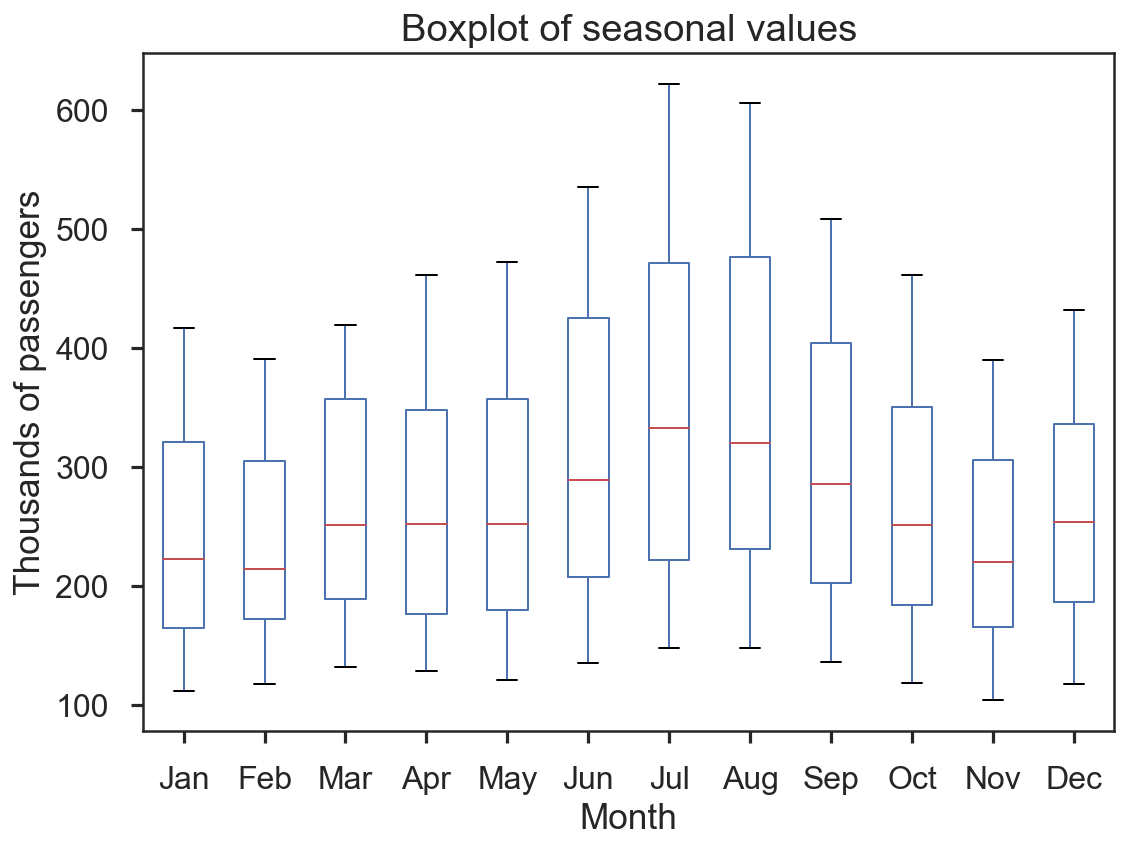

In [7]:
# Here we want to visualise the seasonal trend of air sales tickets

# Create date columns
air['Month'] = air.index.strftime('%b')
air['Year'] = air.index.year

# Here we want to pivot the dates and columns
air_piv = air.pivot(index='Year', columns='Month',values='n_pass_thousands')

# Drop the values
air = air.drop(['Month','Year'], axis = 1)

# put the months in order
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
air_piv = air_piv.reindex(columns=month_names)

# Visualise the seasonal trend with a boxplot
fig, ax = plt.subplots(figsize=(8,6))
air_piv.plot(ax = ax, kind='box');

ax.set_xlabel("Month");
ax.set_ylabel("Thousands of passengers")
ax.set_title("Boxplot of seasonal values");
ax.xaxis.set_ticks_position('bottom');
fig.tight_layout()

_____

### Annual Average Global Temperature Change dataset (fluctuations)


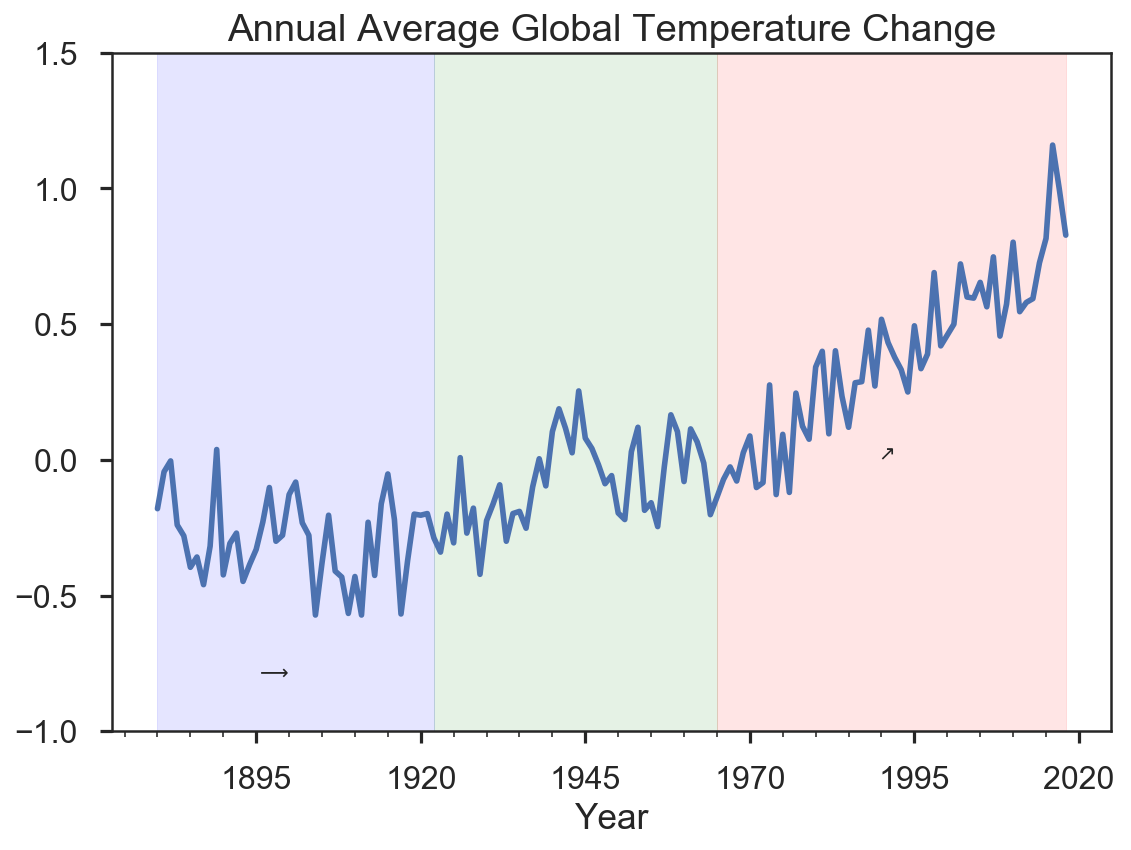

In [11]:
# Load the data in
gtemp = pd.read_csv('data/mixedGLB.Ts.ERSSTV5.GHCN.CL.PA.csv', header=1, index_col=0, parse_dates=[0])

# Take the average are temperature for a given time series
gtemp['avg'] = gtemp.iloc[:,:12].mean(axis=1)

# Visualise the dataset
fig, ax = plt.subplots(figsize=(8,6));
gtemp['avg'].plot(ax = ax);

# Config plot details
ax.set_title("Annual Average Global Temperature Change");
ylim = (-1.0,1.5)
ax.set_ylim(ylim)

# Highlight the different splits in temperature change
ax.fill_betweenx(ylim, gtemp.index[0], pd.Timestamp('1922'), alpha=.1, zorder=-1, color='b');
ax.fill_betweenx(ylim, pd.Timestamp('1922'), pd.Timestamp('1965'), alpha=.1, zorder=-1, color='g')
ax.fill_betweenx(ylim, pd.Timestamp('1965'), gtemp.index[-1], alpha=.1,zorder=-1,color='r')

# Annotate to visualise the importance
ax.annotate('$\\longrightarrow$', (gtemp.index[15], -0.8));
ax.annotate('$\\nearrow$', (gtemp.index[-30], 0));
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [10]:
# First time stamp
gtemp.index[0]

Timestamp('1880-01-01 00:00:00')

### Dow Jones Industrial Average

This dataset shows a weakly stationary process.

### Pattern 3: Variation around a Stable Mean
#### Helper code for loading the data
Dow Jones Industrial Average
- `data/dji.csv`

```python
import pandas_datareader.data as web

start = pd.Timestamp('2006-04-20')
end = pd.Timestamp('2016-04-20')

dji = web.DataReader('DJIA', 'fred', start, end)

dji['Return_log'] = dji['DJIA'].apply(lambda x: np.log(x)).diff()

dji.to_csv('data/dji.csv')
```

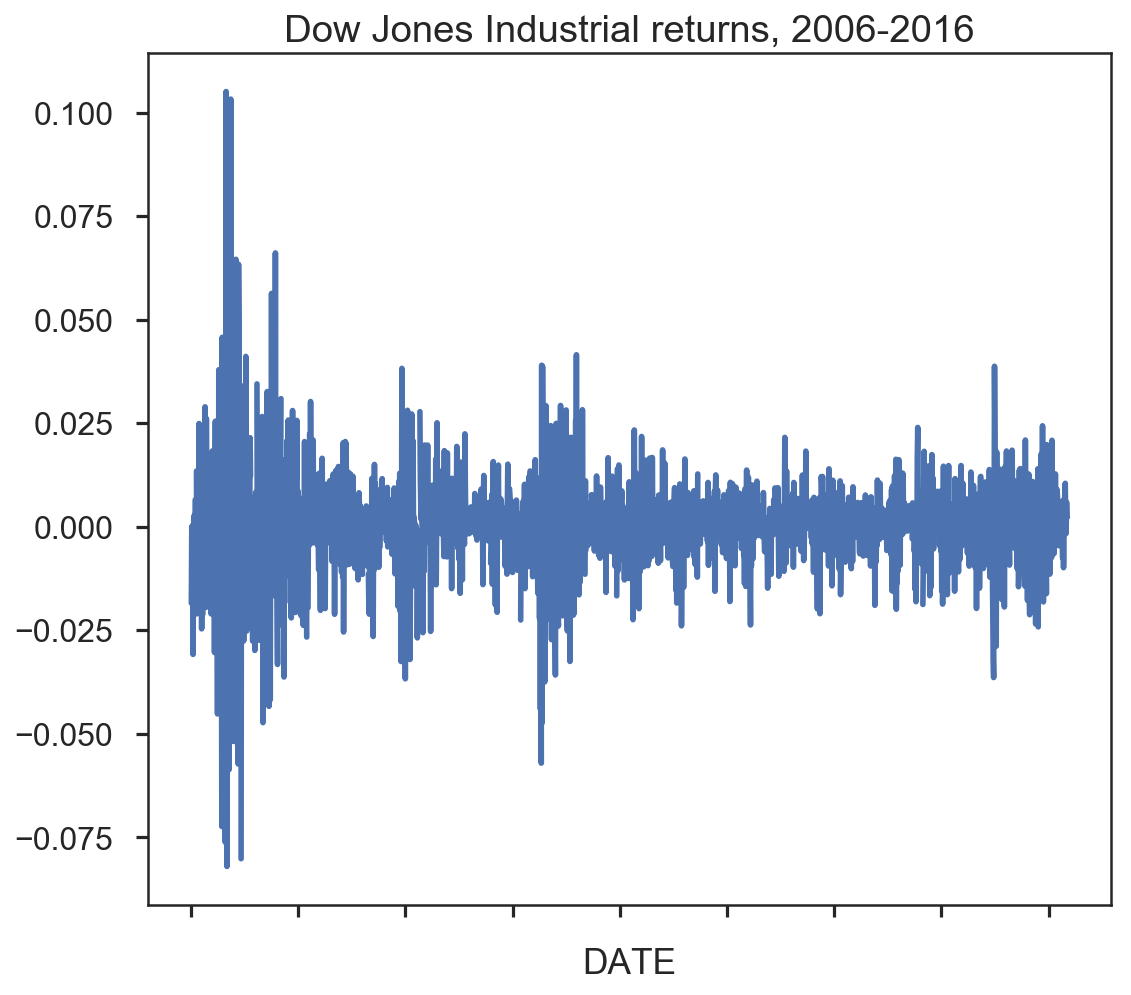

In [16]:
dji = pd.read_csv('data/dji.csv', header=0, index_col=0)

fig, ax = plt.subplots(figsize=(8, 7))

dji['Return_log'].plot(ax=ax);

ax.set_title('Dow Jones Industrial returns, 2006-2016');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Number of annual sunspots (Cyclical)

In [12]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [13]:
sun = sm.datasets.sunspots.load_pandas().data
sun['YEAR'] = pd.to_datetime(sun['YEAR'].astype(int), format='%Y')
sun = sun.set_index('YEAR')

In [14]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

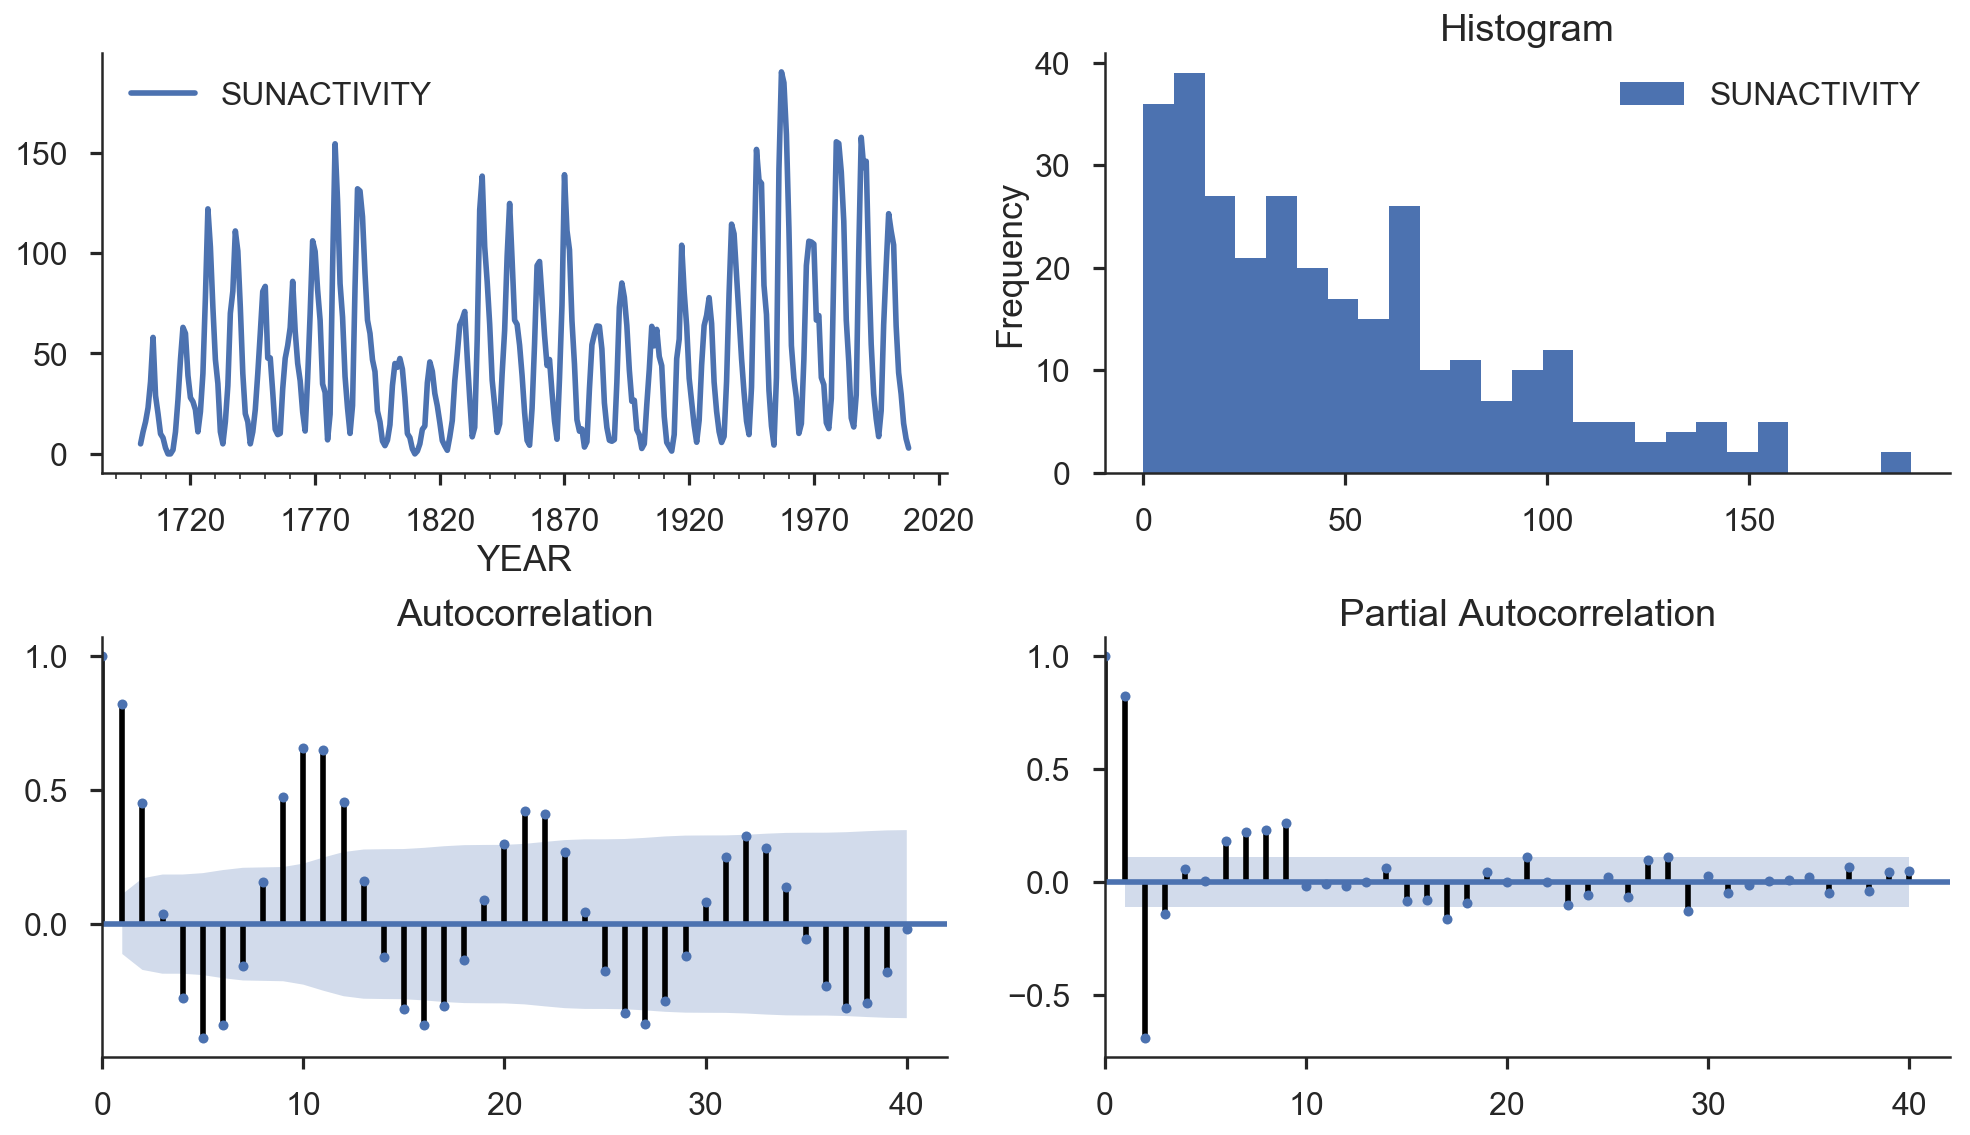

In [15]:
# Here we are plotting to see whether the time series data set contains
# a trend, or some seasonality pattern, as well as ACF and PACF

tsplot(sun, lags=40);

## Plot and model data generated from ARIMA process

In [16]:
def generate_arima_data(arparams,
                        maparams,
                        i_order=0,
                        n_samp=120,
                        rng_state=None,
                        sigma=1,
                        burnin=10,
                        lin_trend=None,
                        verbose=True,
                        ):
    
    if rng_state is None:
        rng_state = np.random.RandomState()
    ar = np.r_[1, -arparams] # add zero-lag and negate
    ma = np.r_[1, maparams] # add zero-lag
    
    if verbose:
        arma_process = sm.tsa.ArmaProcess(ar, ma, nobs=n_samp)
        print('Is the process stationary? {}'.format(arma_process.isstationary))
        print('Is the process invertible? {}'.format(arma_process.isinvertible))

    y = sm.tsa.arma_generate_sample(ar, ma, n_samp, sigma=sigma, distrvs=rng_state.randn, burnin=burnin)
    # add deterministic linear trend
    if lin_trend is not None:
        y = y + np.cumsum(np.repeat(lin_trend, n_samp))
    for i in range(i_order):
        y = y.cumsum()
    
    return y

In [17]:
# the function for generating data and plotting
def arima_data(n_samp=120,
               ar_order=0,
               ar_lag1=0,
               ar_lag2=0,
               ar_lag3=0,
               ar_lag4=0,
               i_order=0,
               ma_order=0,
               ma_lag1=0,
               ma_lag2=0,
               ma_lag3=0,
               ma_lag4=0,
               rand_state=42,
               ylim=5,
               p=0,
               d=0,
               q=0,
               n_train=108,
               n_forecast=24,
               dynamic=False,
               lin_trend=None,
               verbose=True,
               ):
    
    rng_state = np.random.RandomState(rand_state)

    arparams = np.array([ar_lag1, ar_lag2, ar_lag3, ar_lag4])
    arparams = arparams[:ar_order]
    maparams = np.array([ma_lag1, ma_lag2, ma_lag3, ma_lag4])
    maparams = maparams[:ma_order]
    
    print('Generated ARIMA({}, {}, {})'.format(ar_order, i_order, ma_order))
    print('AR coeff = {}, MA coeff = {}'.format(arparams, maparams))
    
    y = generate_arima_data(arparams,
                            maparams,
                            i_order,
                            n_samp=n_samp,
                            rng_state=rng_state,
                            lin_trend=lin_trend,
                            verbose=verbose,
                            )
    
    # set a fake DatetimeIndex
    df = pd.DataFrame(data=y, columns=['value'], index=pd.date_range(start='1990-01-01', freq='MS', periods=len(y)))
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    
    #     # no DatetimeIndex
    #     ax1.plot(y[:n_train], label='In-sample data', linestyle='-')
    #     # subtract 1 only to connect it to previous point in the graph
    #     ax1.plot(np.arange(n_train-1, len(y), 1), y[n_train-1:], label='Held-out data', linestyle='--')
    
    # yes DatetimeIndex
    ax1.plot(df.iloc[:n_train]['value'], label='In-sample data', linestyle='-')
    # subtract 1 only to connect it to previous point in the graph
    ax1.plot(df.iloc[n_train-1:]['value'], label='Held-out data', linestyle='--')

    fitting=False
    if (((ar_order > 0) and (ar_lag1 != 0)) or ((ma_order > 0) and (ma_lag1 != 0))) and ((p > 0) or (q > 0)):
        fitting=True
        print('Fit ARIMA({}, {}, {})'.format(p, d, q))
        # # no DatetimeIndex
        # training = y[:n_train]
        
        # yes DatetimeIndex
        training = df.iloc[:n_train]['value']
        
        if (lin_trend is not None) and (lin_trend > 0):
            #trend='t'
            
            # there's a bug in statsmodels 0.8.0rc1 regarding trend that has been fixed
            # https://github.com/statsmodels/statsmodels/issues/3111
            trend='n'
        else:
            trend='n'
        model = sm.tsa.SARIMAX(training, order=(p, d, q),
                               trend=trend,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               )
        results = model.fit()
        
        #         # no DatetimeIndex
        #         pred_begin = results.loglikelihood_burn
        #         pred_end = n_train + n_forecast - 1
        #         pred = results.get_prediction(start=pred_begin,
        #                                       end=pred_end,
        #                                       dynamic=dynamic)
        #         pred_mean = pred.predicted_mean
        #         pred_ci = pred.conf_int(alpha=0.05)

        #         # overwrite the index if necessary so it plots correctly
        #         pred_ci.index = pd.RangeIndex(start=pred_begin, stop=pred_end+1)
        #
        #         ax1.plot(np.arange(pred_begin, pred_end+1, 1), pred_mean, 'r', alpha=.6, label='Predicted values')
        #         ax1.fill_between(pred_ci.index,
        #                          pred_ci.iloc[:, 0],
        #                          pred_ci.iloc[:, 1], color='k', alpha=.2)
        #         ax1.set_xlim((0, n_train+n_forecast-1))
        #         # plot the residuals
        #         resid = y[pred_begin:] - pred_mean[:-(len(pred_mean) + results.loglikelihood_burn - len(y))]
        #         ax2.plot(resid, marker='o')
        #         ax2.set_xlim((0, n_train+n_forecast-1))
        #         ax2.set_title('Residuals ($data - model$)');
        #         ax2.axhline(y=0, linestyle='--', color='k', alpha=.5);
        
        # yes DatetimeIndex
        pred_begin = df.index[results.loglikelihood_burn]
        pred_end =  df.index[n_train] + pd.DateOffset(months = n_forecast - 1)
        pred = results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                      end=pred_end.strftime('%Y-%m-%d'),
                                      dynamic=dynamic)
        pred_mean = pred.predicted_mean
        pred_ci = pred.conf_int(alpha=0.05)
        
        ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
        ax1.fill_between(pred_ci.index,
                         pred_ci.iloc[:, 0],
                         pred_ci.iloc[:, 1], color='k', alpha=.2)
        # plot the residuals
        (df['value'] - pred_mean).dropna().plot(ax=ax2, marker='o')
        ax2.set_xlim((df.index[0], pred_end))
        ax2.set_title('Residuals ($data - model$)');
        ax2.axhline(y=0, linestyle='--', color='k', alpha=.5);
        
    # scale with i_order
    ylim = ylim*(10**(i_order))
    ax1.set_ylim((-ylim, ylim));
    ax1.legend(loc='best');
    
    if fitting:
        #         # no DatetimeIndex
        #         ax1.fill_betweenx(ax1.get_ylim(), n_train, pred_end, alpha=.1, zorder=-1)
        #         ax2.fill_betweenx(ax2.get_ylim(), n_train, pred_end, alpha=.1, zorder=-1)
        
        # yes DatetimeIndex
        ax1.fill_betweenx(ax1.get_ylim(), df.index[n_train], pred_end, alpha=.1, zorder=-1)
        ax2.fill_betweenx(ax2.get_ylim(), df.index[n_train], pred_end, alpha=.1, zorder=-1)
        plt.show();
        print(results.summary())
    #fig.tight_layout()
    pass

In [18]:
# set up the widgets
n_samp=120

n_train=108
n_forecast=24

rand_state_init=42
ylim_init=5

# orders
int_min = 0
int_max = 4
int_step = 1

ar_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)
i_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)
ma_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)

# coefficients
lag_min = -1
lag_max = 1
lag_step = 0.1

ar_lag1_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar_lag2_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar_lag3_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar_lag4_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)

ma_lag1_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma_lag2_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma_lag3_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma_lag4_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)

rand_slider = IntSlider(value=rand_state_init, min=0, max=10000, step=1, continuous_update=False)
ylim_slider = IntSlider(value=ylim_init, min=1, max=100, step=1, continuous_update=False)

p_init=0
d_init=0
q_init=0
p_slider = IntSlider(value=p_init, min=int_min, max=int_max, step=int_step, continuous_update=False)
d_slider = IntSlider(value=d_init, min=int_min, max=int_max, step=int_step, continuous_update=False)
q_slider = IntSlider(value=q_init, min=int_min, max=int_max, step=int_step, continuous_update=False)

# dynamic_init=n_train
# dynamic_slider = IntSlider(value=dynamic_init, min=n_train-10, max=n_train+1, step=int_step, continuous_update=False)

# lin_trend_init = 0
# lin_trend_slider = FloatSlider(value=lin_trend_init, min=0, max=1.0, step=0.1, continuous_update=False)

arima_w = interactive(
    arima_data,
    n_samp=fixed(n_samp),
    ar_order=ar_slider,
    ar_lag1=ar_lag1_slider,
    ar_lag2=ar_lag2_slider,
    ar_lag3=ar_lag3_slider,
    ar_lag4=ar_lag4_slider,
    i_order=i_slider,
    ma_order=ma_slider,
    ma_lag1=ma_lag1_slider,
    ma_lag2=ma_lag2_slider,
    ma_lag3=ma_lag3_slider,
    ma_lag4=ma_lag4_slider,
    rand_state=rand_slider,
    ylim=ylim_slider,
    p=p_slider,
    d=d_slider,
    q=q_slider,
    n_train=fixed(n_train),
    n_forecast=fixed(n_forecast),
    dynamic=fixed(False),
    #dynamic=dynamic_slider,
    lin_trend=fixed(None),
    #lin_trend=lin_trend_slider,
    verbose=fixed(True),
    )

# arrange the widgets
arima_widget = widgets.HBox([widgets.VBox(arima_w.children[:11]),
                             widgets.VBox(arima_w.children[11:]),
                             ])
# this is the set of widgets in the function with defaults
arima_widget.on_displayed(lambda x: arima_data(ar_order=0,
                                                ar_lag1=0,
                                                ar_lag2=0,
                                                ar_lag3=0,
                                                ar_lag4=0,
                                                i_order=0,
                                                ma_order=0,
                                                ma_lag1=0,
                                                ma_lag2=0,
                                                ma_lag3=0,
                                                ma_lag4=0,
                                                rand_state=rand_state_init,
                                                ylim=ylim_init,
                                                p=p_init,
                                                d=d_init,
                                                q=q_init,
                                                n_train=n_train,
                                                #dynamic=dynamic_init,
                                                #lin_trend=lin_trend_init,
                                                ))

Generated ARIMA(0, 0, 0)
AR coeff = [], MA coeff = []
Is the process stationary? True
Is the process invertible? True


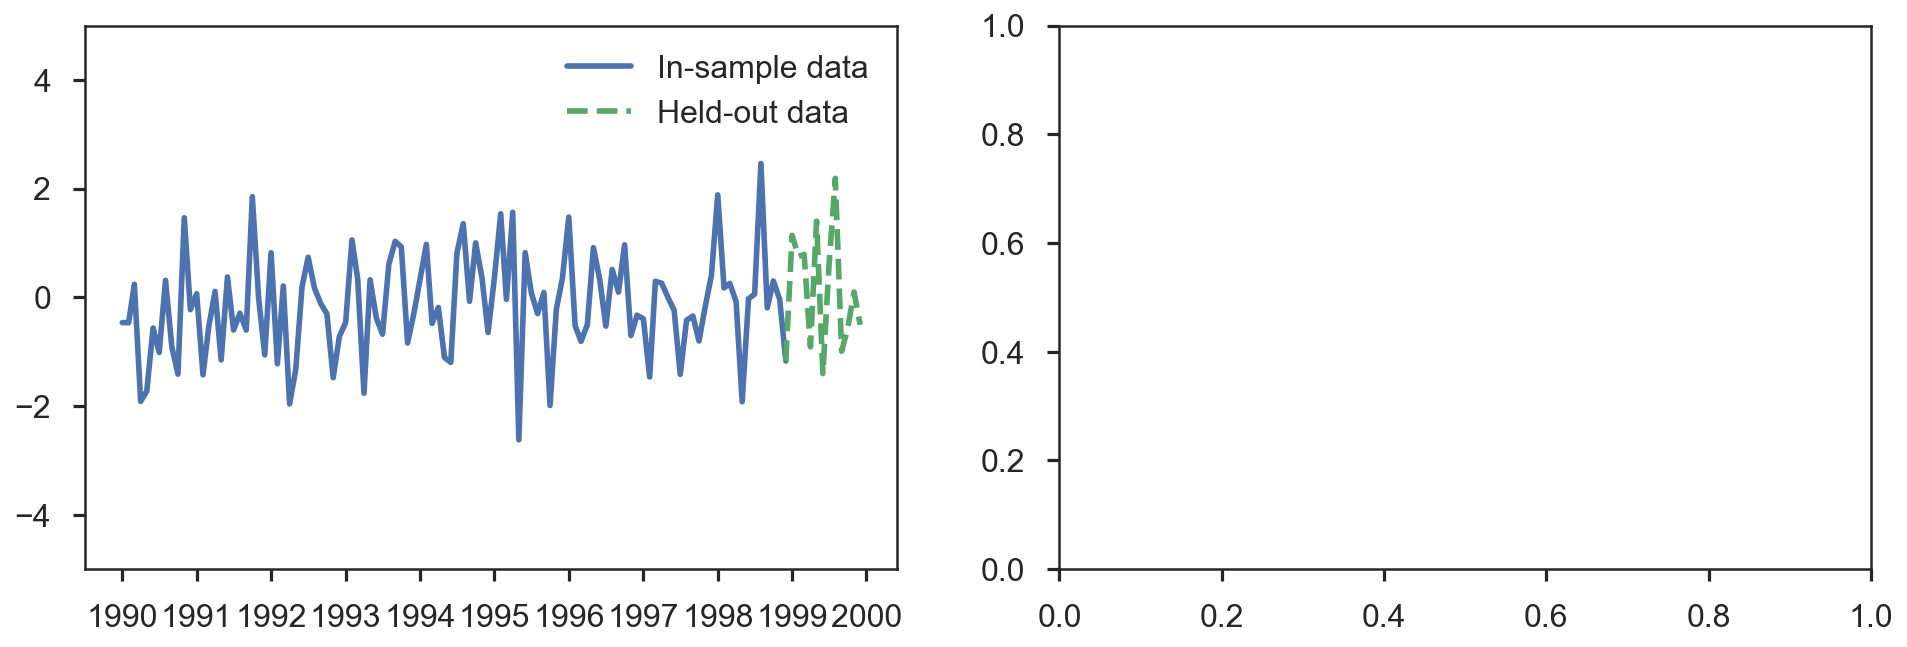

In [19]:
arima_widget